_python notebook №1_

## Transfer Learning в задаче бинарной классификации рентгеновских снимков
Целью является создание модели грубокого машинного обучения, способной с высокой степенью точности (accuracy) определять наличие и отсутствие пнемонии по рентгеновским снимкам грудной клетки. </br>
В процессе исследования будет проведенен процесс предподготовки данных с применением аугментации, оценен вклад метода переноса обучения для данной задачи по классификации, будут определены гиперпараметры, позволяющие добиться высокой accuracy на тестовом датасете для каждой использованной предобученной модели.

In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
from torchvision import transforms, models
%matplotlib inline

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Стадия предварительной обработки данных

In [9]:
pwd = os.getcwd()
list_folders = os.listdir('chest_xray')
print('Текущее расположение репозитория', pwd)
print('Список папок', list_folders)

Текущее расположение репозитория D:\Python_notebooks\repository_Koldim2001\transfer_learning_CNN
Список папок ['test', 'train', 'val']


Определим число изображений в каждой из папок:

In [10]:
img_test_normal = os.listdir('chest_xray/test/NORMAL')
img_test_pathology = os.listdir('chest_xray/test/PNEUMONIA')
img_train_normal = os.listdir('chest_xray/train/NORMAL')
img_train_pathology = os.listdir('chest_xray/train/PNEUMONIA')
img_val_normal = os.listdir('chest_xray/val/NORMAL')
img_val_pathology = os.listdir('chest_xray/val/PNEUMONIA')

In [11]:
print('Суммарно изображений в тестовом датасете:',
      len(img_test_normal)+len(img_test_pathology))
print('Суммарно изображений в трейновом датасете:',
      len(img_train_normal)+len(img_train_pathology))
print('Суммарно изображений в валидационном датасете:',
      len(img_val_normal)+len(img_val_pathology))

Суммарно изображений в тестовом датасете: 624
Суммарно изображений в трейновом датасете: 5216
Суммарно изображений в валидационном датасете: 16


В валидационном датасете присутвует слишком мало изображений, так что я объединю тестовый и валидационный датасеты и потом примерно 50 на 50 поделю

In [12]:
print('в трейновом датасете:\n норма:', len(img_train_normal),
      'изображений \n пневмония:', len(img_train_pathology), 'изображений')

в трейновом датасете:
 норма: 1341 изображений 
 пневмония: 3875 изображений


Так как в тренировочном датасете число изображений с патологией превышает число изображений без нее, то искусственно увеличим датасет нормы, сделав дублирование фотографий нормы. Это позволит снизить эффект диспропорции классов

Некоторые фотки в датасете являются цветными, так что переведем все в чб чтобы не было ошибок

In [13]:
path_train_n = 'chest_xray/train/NORMAL'
df_train = pd.DataFrame()
pixel_h = []
pixel_l = []
for im in img_train_normal:
    image_file = Image.open((os.path.join(path_train_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_train = pd.concat([df_train, df_row])
    
    
path_train_p = 'chest_xray/train/PNEUMONIA'
for im in img_train_pathology:
    image_file = Image.open((os.path.join(path_train_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_train = pd.concat([df_train, df_row])

Создал трейновый датасет состоящий из двух столбцов. В первом лежит двумерный массив интенсивности пикселей чб изображений в диапазоне от 0 до 255. Во втором столбце класс, соответствующий данному изображению.

In [14]:
df_train

,image_data,class
0,"[[22, 24, 24, 23, 22, 23, 23, 23, 20, 20, 20, ...",normal
0,"[[11, 11, 15, 15, 15, 18, 19, 24, 26, 24, 23, ...",normal
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",normal
0,"[[36, 38, 40, 41, 40, 40, 41, 43, 44, 45, 47, ...",normal
0,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...",normal
...,...,...
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pneumonia
0,"[[95, 94, 95, 96, 92, 89, 93, 100, 99, 97, 96,...",pneumonia
0,"[[23, 23, 24, 24, 23, 23, 22, 21, 23, 22, 20, ...",pneumonia
0,"[[32, 31, 30, 28, 28, 29, 30, 31, 37, 35, 33, ...",pneumonia


Все подписи на графиках будут вестись на анлийском языке для возможности публикации результатов исследования в англоязычных источниках

Изучим размерности исходных снимков в трейновом датасете:

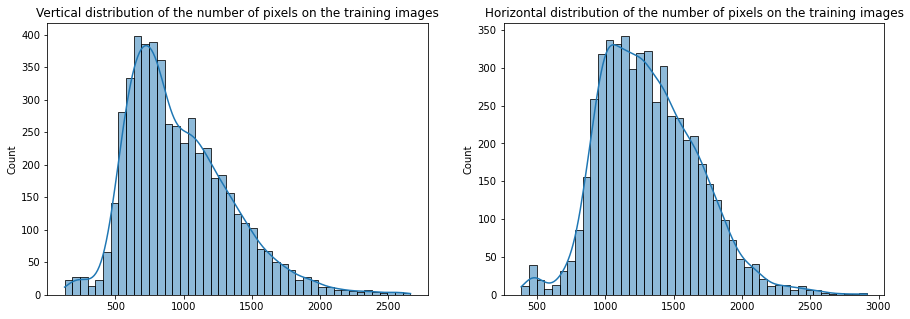

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=pixel_h, kde=True)
plt.title('Vertical distribution of the number of pixels on the training images')  
plt.subplot(1, 2, 2)
sns.histplot(x=pixel_l, kde=True)
plt.title('Horizontal distribution of the number of pixels on the training images')
plt.show()

In [16]:
path_test_n = 'chest_xray/test/NORMAL'
df_test = pd.DataFrame()
pixel_h = []
pixel_l = []
for im in img_test_normal:
    image_file = Image.open((os.path.join(path_test_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_test = pd.concat([df_test, df_row])
    
path_test_p = 'chest_xray/test/PNEUMONIA'
for im in img_test_pathology:
    image_file = Image.open((os.path.join(path_test_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_test = pd.concat([df_test, df_row])
    
# Присоединим еще и val дататсет состоящий всего лишь из 16 снимков к тестовому:

path_val_n = 'chest_xray/val/NORMAL'
for im in img_val_normal:
    image_file = Image.open((os.path.join(path_val_n, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['normal']})
    df_test = pd.concat([df_test, df_row])
    
path_val_p = 'chest_xray/val/PNEUMONIA'
for im in img_val_pathology:
    image_file = Image.open((os.path.join(path_val_p, im))) # open colour image
    image_file= image_file.convert('L')
    image = np.asarray(image_file)
    pixel_h.append(image.shape[0])
    pixel_l.append(image.shape[1])
    df_row = pd.DataFrame({'image_data':[image],
                             'class':['pneumonia']})
    df_test = pd.concat([df_test, df_row])

Изучим размерности исходных снимков в тестовом датасете:

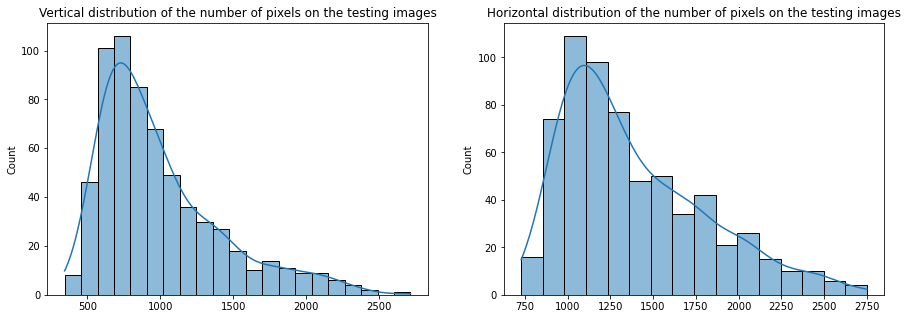

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=pixel_h, kde=True)
plt.title('Vertical distribution of the number of pixels on the testing images')  
plt.subplot(1, 2, 2)
sns.histplot(x=pixel_l, kde=True)
plt.title('Horizontal distribution of the number of pixels on the testing images')
plt.show()

Перед тем как разделить на test и validation рандомно перемешаем строки датафрема

In [18]:
df_test = df_test.iloc[np.random.RandomState(seed=42).permutation(len(df_test))]
df_test, df_val = np.array_split(df_test, 2) # Делим пополам
df_test['class'].count()

320

Теперь в тестовой и валидационной выборках равное чило данных. (320 в каждом)

In [19]:
df_test['class'].value_counts()

pneumonia    191
normal       129
Name: class, dtype: int64

In [20]:
df_val['class'].value_counts()

pneumonia    207
normal       113
Name: class, dtype: int64

Сделаем пропорции классов в трейновом датасете равной 50 на 50:

In [21]:
df_train['class'].value_counts()

pneumonia    3875
normal       1341
Name: class, dtype: int64

In [22]:
count_class_1 = len(df_train[df_train['class']=='pneumonia'])
count_class_0 = len(df_train[df_train['class']=='normal'])
dif = count_class_1 - count_class_0

Удалим раномные строки из датафрейма где класс равен pneumonia, чтобы число элементов обоих классов сравнялось

In [23]:
df_train = df_train.reset_index(drop=True)

In [24]:
df_train = df_train.drop(df_train[df_train['class']=='pneumonia'].sample(n=dif,random_state=42).index)

In [25]:
df_train['class'].value_counts()

normal       1341
pneumonia    1341
Name: class, dtype: int64

In [26]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

Создадим MakeDataset класс, который потом будем импользовать для реализации Dataloader:

In [27]:
class MakeDataset(Dataset):
    def __init__(self, df, transform=None):
        df = df.to_numpy()
        self.x = df[:,0]
        self.y = df[:,2]
        self.n_samples = df.shape[0]
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index]/225 #привел значения тензоров к дапазону от 0 до 1
        sample = np.float32(sample)
        sample = torch.tensor(np.expand_dims(sample, axis=0)) #добавил канал 1 
        # теперь данные - тензор 1 х H x W
        
        if self.transform is not None:
            sample = self.transform(sample)
        return (sample,  torch.tensor([self.y[index]]))
        
    def __len__(self):
        return self.n_samples

1 - индекс (label) у класса "Наличие пневмонии" <br/>
0 - индекс (label) у класса "Норма"

In [28]:
df_test['label'] = df_test['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)
df_val['label'] = df_val['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)
df_train['label'] = df_train['class'].apply(lambda x: 1.0 if x=='pneumonia' else 0)

In [29]:
df_train.head()

,image_data,class,label
0,"[[22, 24, 24, 23, 22, 23, 23, 23, 20, 20, 20, ...",normal,0.0
1,"[[11, 11, 15, 15, 15, 18, 19, 24, 26, 24, 23, ...",normal,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",normal,0.0
3,"[[36, 38, 40, 41, 40, 40, 41, 43, 44, 45, 47, ...",normal,0.0
4,"[[75, 77, 74, 73, 74, 72, 68, 71, 67, 64, 64, ...",normal,0.0


Так как датасет на трейне небольшой, поэтому проведем аугментацию изображений:

Будем осуществлять нормализацию входных данных. Для этого определим величину mean и std по train датасету:

In [30]:
dataset =  MakeDataset(df_train, transform=transforms.Resize((224,224)))
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=0)

In [31]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += (images).mean(2).sum(0)
        std += (images).std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

In [32]:
mean_nums, std_nums = get_mean_std(loader)
print('mean =', mean_nums, 'std =', std_nums)

mean = tensor([0.5455]) std = tensor([0.2587])


__Создадим трансформации для датасетов:__<br>
Для тестового будет использоваться лишь однократно трансформация (это будет изменение размера до 224 на 224 и нормализация)
<br><br>
Для train датасета будет использоваться 4 различных трансформации, которые позволят увеличить размер исходного датасета в 4 раза. Будет происходить наращивания (конкатинации) датасетов прошедших три различных трасформации:<br>
1) Изменение угла поворота изображения + сжатие изображения + нормализация <br>
2) Симметричное отображение вокруг вертикали + сжатие изображения + нормализация <br>
3) Изенение параметров яркости, контраста и насыщенности + сжатие изображения + нормализация<br>
4) Сначала будет сжато изображение до размеров 280 на 280 потом рандомно вырежется часть размером 224 на 224, далее с верояностью 0.5 произойдет отражение вокруг горизонтали как в трасформации №2 и потом небольшое рандомное вращение от 0 до 5 градусов + нормализация   

Трансформацию в тензор я не провожу так как данную трансформацию уже реализовал сразу в методе getitem класса MakeDataset

In [33]:
transforms_train_1 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.RandomRotation(20),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_2 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(p=1),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_3 = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ColorJitter(brightness=0.3,
                                                                contrast=0.1,
                                                                saturation=0.1),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

transforms_train_4 = transforms.Compose([transforms.Resize((280,280)),
                                         transforms.RandomCrop(size=(224, 224)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.RandomRotation(5),
                                         transforms.Normalize(mean = mean_nums, std=std_nums)])

# Теперь опишем трасформации для валидационного и тестового датасетов:
                               
transforms_check = transforms.Compose([transforms.Resize((224,224)), 
                                       transforms.Normalize(mean = mean_nums, std=std_nums)]) 

Генерация датасетов:

In [34]:
dataset_test = MakeDataset(df_test, transform=transforms_check)
dataset_val = MakeDataset(df_val, transform=transforms_check)

In [35]:
# Проверка возможности итерироваться по датасету
first = dataset_test[0]
features, labels = first
print(features, labels)

tensor([[[-2.0429, -2.0429, -2.0800,  ..., -2.0401, -2.0401, -2.0401],
         [-2.0828, -2.0828, -2.1001,  ..., -2.0401, -2.0656, -2.0656],
         [-2.1088, -2.1088, -1.9078,  ..., -2.0401, -2.0607, -2.0883],
         ...,
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542],
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542],
         [-1.9542, -1.9542, -1.9714,  ..., -1.9714, -1.9542, -1.9542]]]) tensor([1.])


In [36]:
features.shape

torch.Size([1, 224, 224])

In [37]:
dataset_train_1 = MakeDataset(df_train, transform=transforms_train_1)
dataset_train_2 = MakeDataset(df_train, transform=transforms_train_2)
dataset_train_3 = MakeDataset(df_train, transform=transforms_train_3)
dataset_train_4 = MakeDataset(df_train, transform=transforms_train_4)

Первый вид трансформации:

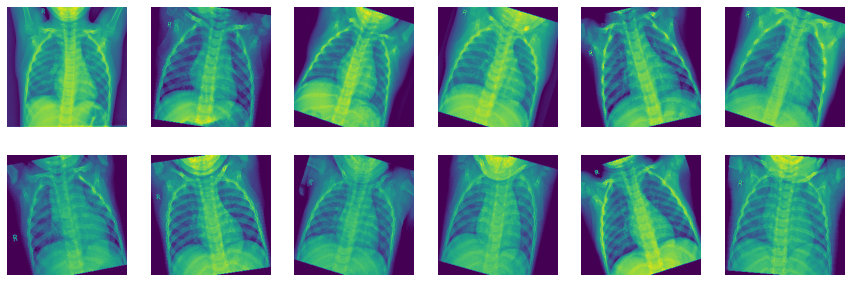

In [38]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_1[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Второй вид трансформации:

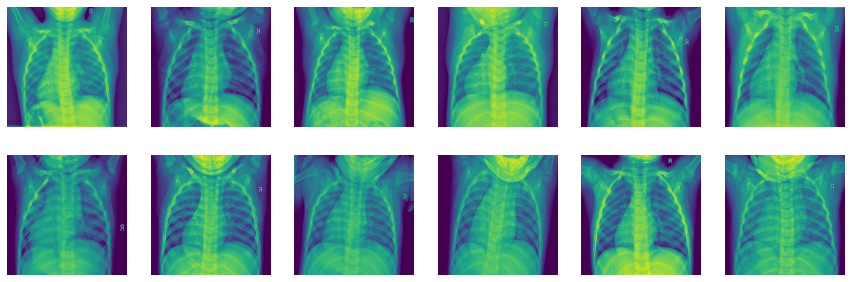

In [39]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_2[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Третий вид трансформации:

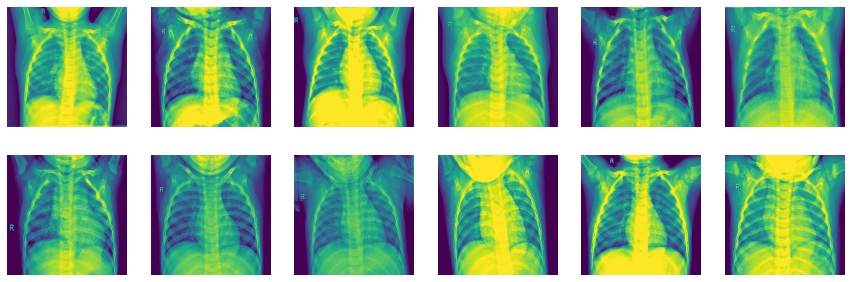

In [40]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_3[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

Третий вид трансформации:
    

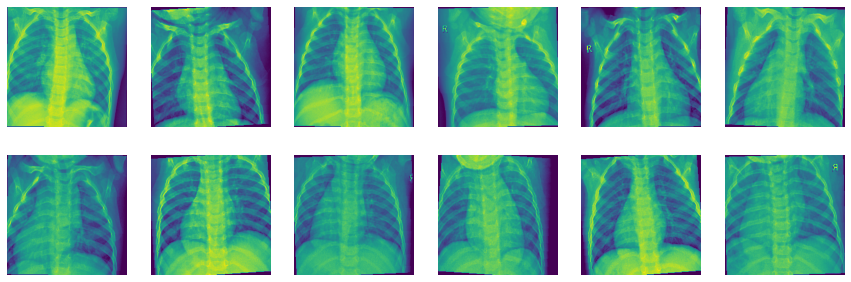

In [41]:
fig, axes = plt.subplots(2, 6, figsize=(15,5))
for i, ax in enumerate(axes.flatten()):
    first = dataset_train_4[i]
    features, labels = first
    image = np.transpose(features,(1,2,0))
    ax.imshow(image)
    ax.axis('off')
plt.show()

In [42]:
print('Число изображений в исходном train датасете =', len(dataset_train_1))

Число изображений в исходном train датасете = 2682


In [43]:
# Сконкатинируем получившиеся датасеты:
dataset_train = torch.utils.data.ConcatDataset([dataset_train_1,
                                                dataset_train_2,
                                                dataset_train_3,
                                                dataset_train_4])

In [44]:
print('Число изображений в получившемся train датасете =', len(dataset_train))

Число изображений в получившемся train датасете = 10728


---

Зададим устройство для вычислений: CPU или GPU

In [45]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [46]:
batch_size = 10 # зададим размер батча

In [47]:
dataloader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

In [48]:
def imshow(img):
    img = img *std_nums + mean_nums  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

Посмотрим как лежат фотки в батчах на тесте:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


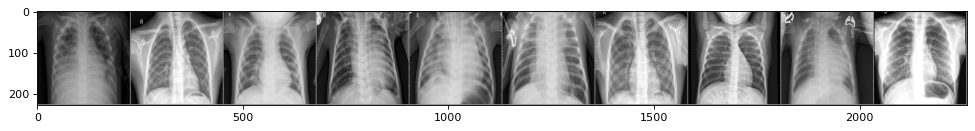

GroundTruth:  pneumonia,  norm,  pneumonia,  pneumonia,  pneumonia,  pneumonia,  norm,  norm,  pneumonia,  norm


In [49]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_test))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

Посмотрим как лежат фотки в батчах на трейне:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


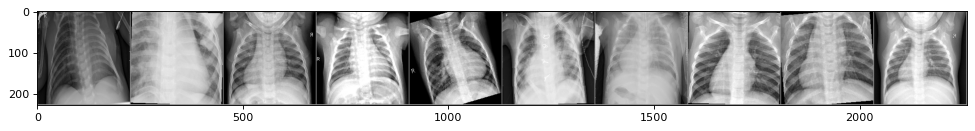

GroundTruth:  pneumonia,  pneumonia,  norm,  norm,  pneumonia,  pneumonia,  pneumonia,  norm,  norm,  norm


In [50]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(dataloader_train))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
# выводим изображения в батче
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ',  '.join( classes[int(label_batch[j])] for j in range(batch_size)))

### Стадия инициализации и обучения собственной нейронной сетей

In [51]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
print("len(train_dataset) =", len(dataset_train))

val_dataloader= torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
print("len(val_dataset) =", len(dataset_val))

test_dataloader= torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

len(train_dataset) = 10728
len(val_dataset) = 320


Так как в одном батче 10 фотографий, поэтому суммарно на трейне имеется 1073 батчей. Так что 1 эпоха = 1073 градиентных спусков

__Создадим архитектуру сверточной нейронной сети:__ <br>
Данная сеть будет иметь 4 сверточных слоя с применением макс пулинга и активации ReLU и 2 скрытых полносвязных слоя. Выходной слой будет состоять из двух нейронов, так как это задача бинарной классификации.

In [52]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)   #224:224 -размер изображения на выходе 
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)       #112:112
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=10, kernel_size=3, padding=1)  #112:112
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4) #28:28
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=3, padding=1) #28:28
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #14:14
        
        self.conv4 = torch.nn.Conv2d(
            in_channels=10, out_channels=5, kernel_size=3, padding=1) #14:14
        self.act4 = torch.nn.ReLU()


        self.fc1   = torch.nn.Linear(14 * 14 * 5, 50)
        self.act5 = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(50, 30)
        self.act6 = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(30, 2)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)  
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)

          
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        
        x = self.fc2(x)
        x = self.act6(x)
        
        x = self.fc3(x)
        
        return x


model = SimpleConvNet().to(device)

In [53]:
loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор

Зададим lr_scheduler, который постепенно будет в процессе обучения уменьшать величину learning rate.
Благодаря этому мы сможем найти более точно минимум фунции потерь

In [54]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.5)

In [55]:
def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

Создвдим папку, в которую будем сохранять модели с самым высоким значением accuracy на валидации:

In [56]:
directory = pwd + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [57]:
n_epoch = 25 #Зададим число эпох обучения

In [58]:
# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model, directory+'\model_no_TransferLearning.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:29<00:00,  5.11it/s]


[epoch 1] loss: 0.302, acc: 0.872
Validation accuracy - 0.821875


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:24<00:00,  5.24it/s]


[epoch 2] loss: 0.176, acc: 0.934
Validation accuracy - 0.803125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:24<00:00,  5.24it/s]


[epoch 3] loss: 0.153, acc: 0.942
Validation accuracy - 0.78125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:28<00:00,  5.15it/s]


[epoch 4] loss: 0.133, acc: 0.95
Validation accuracy - 0.803125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.22it/s]


[epoch 5] loss: 0.117, acc: 0.957
Validation accuracy - 0.778125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.23it/s]


[epoch 6] loss: 0.0925, acc: 0.967
Validation accuracy - 0.78125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:26<00:00,  5.19it/s]


[epoch 7] loss: 0.0902, acc: 0.968
Validation accuracy - 0.771875


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:22<00:00,  5.29it/s]


[epoch 8] loss: 0.086, acc: 0.966
Validation accuracy - 0.7875


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:23<00:00,  5.27it/s]


[epoch 9] loss: 0.0811, acc: 0.969
Validation accuracy - 0.80625


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.21it/s]


[epoch 10] loss: 0.0788, acc: 0.97
Validation accuracy - 0.828125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:24<00:00,  5.26it/s]


[epoch 11] loss: 0.0679, acc: 0.976
Validation accuracy - 0.815625


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:24<00:00,  5.24it/s]


[epoch 12] loss: 0.0663, acc: 0.975
Validation accuracy - 0.79375


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:29<00:00,  5.12it/s]


[epoch 13] loss: 0.0634, acc: 0.978
Validation accuracy - 0.7875


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.22it/s]


[epoch 14] loss: 0.063, acc: 0.978
Validation accuracy - 0.803125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.22it/s]


[epoch 15] loss: 0.0583, acc: 0.978
Validation accuracy - 0.78125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.22it/s]


[epoch 16] loss: 0.0526, acc: 0.98
Validation accuracy - 0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.22it/s]


[epoch 17] loss: 0.052, acc: 0.98
Validation accuracy - 0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:29<00:00,  5.12it/s]


[epoch 18] loss: 0.051, acc: 0.982
Validation accuracy - 0.784375


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:25<00:00,  5.21it/s]


[epoch 19] loss: 0.0516, acc: 0.981
Validation accuracy - 0.8062499999999999


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:26<00:00,  5.20it/s]


[epoch 20] loss: 0.0485, acc: 0.981
Validation accuracy - 0.78125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:29<00:00,  5.11it/s]


[epoch 21] loss: 0.0437, acc: 0.985
Validation accuracy - 0.79375


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:27<00:00,  5.18it/s]


[epoch 22] loss: 0.0452, acc: 0.984
Validation accuracy - 0.803125


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:26<00:00,  5.19it/s]


[epoch 23] loss: 0.0459, acc: 0.983
Validation accuracy - 0.7906249999999999


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:30<00:00,  5.09it/s]


[epoch 24] loss: 0.0482, acc: 0.983
Validation accuracy - 0.7875


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1073/1073 [03:27<00:00,  5.18it/s]


[epoch 25] loss: 0.0464, acc: 0.983
Validation accuracy - 0.796875
Total time 5253.609 seconds


Посмотрим как в процессе обучения менялись значения accuracy и loss на трейне и валидации:

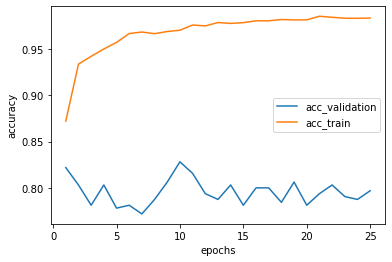

In [59]:
plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

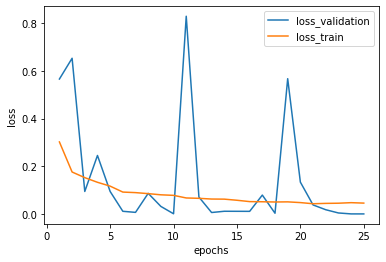

In [60]:
plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

Загрузим лучшую модель:

In [58]:
wghts = torch.load(directory + '/model_no_TransferLearning.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Посмотрим, как модель справляется с задачей постановки диагноза:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


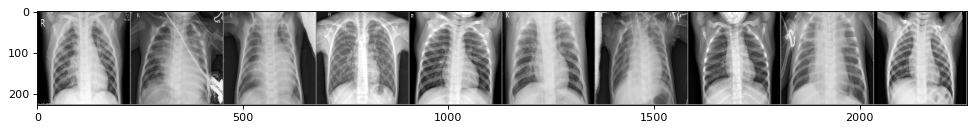

GroundTruth:  pneumonia pneumonia pneumonia  norm  norm pneumonia pneumonia  norm pneumonia  norm
Прогноз:  pneumonia pneumonia pneumonia pneumonia norm pneumonia pneumonia norm pneumonia norm


In [59]:
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

In [60]:
model.eval()
y_true_list = []
y_pred_list = []

correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        y_true_list.append(label_batch.numpy())
        y_pred_list.append(predicted.numpy())

        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 843.75 %


In [61]:
y_pred_list = np.asarray(y_pred_list).flatten()
y_true_list = np.asarray(y_true_list).flatten()

In [62]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       129
           1       0.80      0.98      0.88       191

    accuracy                           0.84       320
   macro avg       0.88      0.81      0.82       320
weighted avg       0.87      0.84      0.84       320



In [63]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

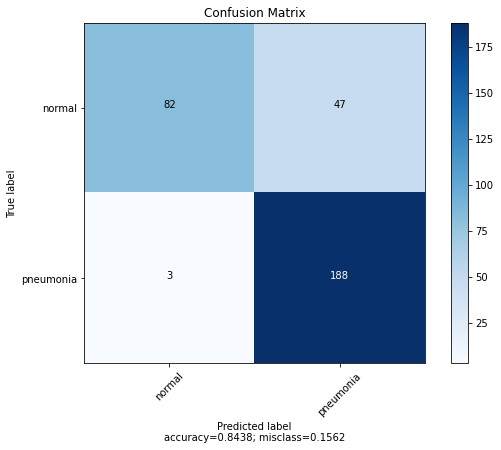

In [64]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Визуализируем фильтры первого слоев, чтобы понять как именно сеть выделяет признаки, говорящие о наличии и отсутствии пнемнонии в самом близком приближении:

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


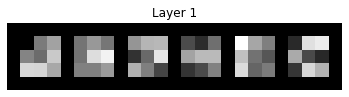

Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [65]:
# получение всех сверточных слоев модели
conv_layers = [layer for layer in model.modules() if isinstance(layer, torch.nn.Conv2d)]

# визуализация фильтров первого сверточного слоя
for i, layer in enumerate(conv_layers):
    print(layer)
    if i == 0:
        filters = layer.weight.data.clone()
        filters -= filters.min()
        filters /= filters.max()
        n_filters, n_channels, filter_height, filter_width = filters.shape
        filters = filters.view(n_filters, n_channels, filter_height, filter_width)
        img = vutils.make_grid(filters, nrow=8, normalize=True, padding=1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Layer {i+1}")
        plt.axis('off')
        plt.show()

Мы получили довольно высокие показатели точности на тесте даже без применения Transfer learning. Это может быть связано с тем, что трейновый датасет благодаря применению аугментации стал достаточно большим для обучения собственных глубоких моделей. В следующем python notebook применим разные виды Transfer learning и посмотрим, получится ли добиться более высоких резутатов на тесте или нет.

Стоит заметить, что recall для класса пневмония равен 98%, что говорит о том, что заболевшие пнемонией практически все будут выявлены. Но при этом при анализе результатов тестового датасета надо всегда учитывать непропорциональность классов. Людей с пневмонией в тестовом датасете представлено примерно в 2 раза больше. Проблему с пропорцией 50 на 50 мы решили на стадии обучения, сделав downsampling, но на тестовой выборке решили оставить как есть, потому что и так немного данных на тесте представлено